In [1]:
import nengo
import nengo_spa as spa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import re

In [2]:
np.random.seed(0)

# Define ToH Environment

In [3]:
class TowerOfHanoi:
    def __init__(self, vocab, disk_count, threshold=0.5, dt=0.001):
        self.dt = dt
        self.D = vocab.dimensions
        self.pstc = 0.01
        self.disk_count = disk_count
        self.threshold = threshold
        
        self.pegs = ['A', 'B', 'C']
        self.disks = ['D{}'.format(i) for i in range(self.disk_count)]
        self.reset()
        
        self.location_dict = {'A':0, 'B':1, 'C':2}  # location_dict[toh.target_peg] -> goal peg
        self.zero = [0]*self.D
        self.vocab = vocab
        
        self.DONE_duration = 0.1
        self.DONE_current = self.DONE_duration # start off marked as DONE
        self.peg_regex = re.compile('[ABC]')
        self.disk_regex = re.compile('D[0-{}]'.format(0, len(self.disks))) # set search to be range to be 1 more than max; ie; one disk -> D0-D1
        
    def reset(self, randomize=True):
        self.location = ['A']*self.disk_count # location of each disk
        #self.focus_disk = len(self.disks) - 1    # focus disk
        self.largest = self.disk_count - 1  # disks have 0 indexing
        self.goal = self.disk_count - 1     # goal disk
        self.target_peg = 'C'
        self.move_peg_data = [0] * self.disk_count
        self.goal_peg_data = [0] * self.disk_count
        # constant
        self.target = ['C'] * self.disk_count
        
    def move(self, disk, peg):
        # disk is string representing the disk in text form (ie. D0)
        # peg is a character representing the text location of either 'A', 'B', or 'C'
        #assert self.can_move(disk, peg)
        disk_index = self.disks.index(disk)
        self.location[disk_index] = peg
        
    def can_move(self, disk, peg):
        # disk is string representing the disk in text form (ie. D0)
        # peg is a character representing the text location of either 'A', 'B', or 'C'
        #// disk is an integer representing the array index for `self.location`
        
        # get index of disk
        disk_index = self.disks.index(disk)
        
        assert peg in 'ABC'
        
        # check that if all disks smaller than `disk` are not at the target peg (smaller disk in the way at target)
        # or that if all disks smaller than `disk` are on the same peg (smaller disk in the way from leaving)
        pegs = [self.location[disk_index], peg]
        for i in range(disk_index):
            if self.location[i] in pegs:
                return False
        return True
    
    def vector_to_disk(self, vector):
        disk_vocab = self.vocab.create_subset(self.disks)        
        return 'D{}'.format(np.argmax(spa.similarity(vector, disk_vocab)))
        
    def __call__(self, t, x):
        #######
        # Input
        #######
        focus_disk_in = x[:self.D]
        goal_peg_in = x[self.D:2*self.D]
        goal_disk_in = x[2*self.D:3*self.D]
        
        # motor cortex input
        move_peg = x[3*self.D:4*self.D]
        move_disk = x[4*self.D:5*self.D]
        
        ############
        # Processing
        ############
        #self.focus_disk = self.vocab.parse(spa.text(focus_disk_in, vocab)).v
        #self.focus_disk = spa.text(focus_disk_in, vocab)
        self.focus_disk = self.vector_to_disk(focus_disk_in)
        
        move_peg_selected = spa.text(move_peg, self.vocab, minimum_count=0, threshold=0.2)
        move_disk_selected = spa.text(move_disk, self.vocab, minimum_count=0, threshold=0.2)
        #print('Move Peg: {}'.format(move_peg_selected))
        #print('Move Disk: {}'.format(move_disk_selected))
        
        if move_peg_selected != '' and move_disk_selected != '':
            # parse peg and disk
            peg_found = self.peg_regex.search(move_peg_selected)
            disk_found = self.disk_regex.search(move_disk_selected)
            if peg_found is None or disk_found is None:
                raise Exception('No Target Peg or Disk found when attempting to move a Disk')
                
            peg = peg_found.group(0)
            disk = disk_found.group(0)
            
            if self.can_move(disk, peg):
                if self.location[self.disks.index(disk)] != peg:
                    print('BEFORE: {}'.format(self.location))
                    self.move(disk, peg)
                    self.DONE_current = self.DONE_duration
                    print('Moving {} to {}'.format(disk, peg))
                    print('AFTER: {}'.format(self.location))
                else:
                    print('Disk {} already at peg {}'.format(disk, peg))
            else:    
                print('Cannot move {} to {}'.format(disk,peg))
        '''
        #self.focus_disk = np.argmax(spa.similarity(focus_disk_in, self.disks))
        self.goal_peg_data = spa.similarity(goal_peg_in, self.disks)
        
        ##
        disks = spa.similarity(goal_disk_in, self.disks)
        pegs = self.goal_peg_data
        if np.max(pegs) > self.threshold and np.max(disks) > self.threshold:
            self.goal = np.argmax(disks)
            self.target_peg = 'ABC'[np.argmax(pegs)]
        
        self.move_peg_data = spa.similarity(move_peg, self.pegs)
        ##
        
        ##
        disks = spa.similarity(move_disk, self.disks)
        disk = np.argmax(disks)
        pegs = self.move_peg_data
        peg = 'ABC'[np.argmax(pegs)] # 'ABC' is a char array
        
        if(np.max(pegs) > self.threshold and np.max(disks) > self.threshold):
            if peg != self.location[disk]:
                if self.can_move(disk, peg):
                    self.move(disk, peg)
                    print('Moving D{} to {}'.format(disk, peg))
                else:    
                    print('Cannot move D{} to {}'.format(disk,peg))
        ##
        '''
        ########
        # Output
        ########
        
        # define output array
        out = [0]*7*self.D
        out[:self.D] = self.vocab.parse(self.disks[self.largest]).v # largest
        out[self.D:2*self.D] = self.vocab.parse(self.focus_disk).v # focus_out
        out[2*self.D:3*self.D] = self.vocab.parse(self.location[self.goal]).v # goal_peg_out
        out[3*self.D:4*self.D] = self.vocab.parse(self.target_peg).v # target_peg
        
        # visual cortex output
        out[4*self.D:5*self.D] = self.vocab.parse(self.disks[self.goal]).v # goal_out
        out[5*self.D:6*self.D] = self.vocab.parse(self.target[self.goal]).v # goal_peg_final
        #out[6*self.D:7*self.D] = self.zero if self.focus_disk >= self.disk_count else self.vocab.parse(self.location[self.focus_disk]).v # focus_peg
        out[6*self.D:7*self.D] = self.vocab.parse(self.location[self.disks.index(self.focus_disk)]).v # focus_peg
        
        out[7*self.D:8*self.D] = self.vocab.parse('~DONE').v if self.DONE_current <= 0 else self.vocab.parse('DONE').v # done
        
        if self.DONE_current > 0:
            self.DONE_current -= self.dt
        if self.DONE_current < 0:
            self.DONE_current = 0
        
        #out_viz = [0]*(3 + len(self.location))
        '''
        out_viz[0] = self.focus_disk                        # focus_viz
        out_viz[1] = self.goal                              # goal_viz
        out_viz[2] = self.location_dict[self.target_peg]    # peg_viz
        for idx, loc in enumerate(self.location):
            out_viz[3 + idx] = self.location_dict[loc]      # pos_viz
        '''
        #out += out_viz
        
        return out
    
    def __str__(self):
        res = '=============================\nTOH Stats\n============================='
        res += '\n    location: {}'.format(self.location)
        #res += '\n    focus_disk: {}'.format(self.focus_disk)
        res += '\n    largest: {}'.format(self.largest)
        res += '\n    goal: {}'.format(self.goal)
        res += '\n    target_peg: {}'.format(self.target_peg)
        res += '\n    move_peg_data: {}'.format(self.move_peg_data)
        res += '\n    goal_peg_data: {}'.format(self.goal_peg_data)
        res += '\n    target: {}'.format(self.target)
        res += '\n============================='
        return res

In [4]:
def toh_node(vocab, disk_count, network_label='TOH Env'):
    D = vocab.dimensions
    toh = TowerOfHanoi(vocab, disk_count)
    with nengo.Network(label='Tower of Hanoi Node', seed=8) as model:
        model.toh_node = nengo.Node(toh, size_in=5*D, size_out=8*D, label=network_label)
        
        # connect inputs
        model.focus_disk_in = spa.State(vocab, D, label='focus_disk_in_state')
        model.goal_peg_in = spa.State(vocab, D, label='goal_peg_in_state')
        model.goal_disk_in = spa.State(vocab, D, label='goal_disk_in_state')
        model.move_peg_in = spa.State(vocab, D, label='move_peg_in_state')
        model.move_disk_in = spa.State(vocab, D, label='move_disk_in_state')
        nengo.Connection(model.focus_disk_in.output, model.toh_node[:D])
        nengo.Connection(model.goal_peg_in.output, model.toh_node[D:2*D])
        nengo.Connection(model.goal_disk_in.output, model.toh_node[2*D:3*D])
        nengo.Connection(model.move_peg_in.output, model.toh_node[3*D:4*D])
        nengo.Connection(model.move_disk_in.output, model.toh_node[4*D:5*D])
        
        # connect outputs
        model.largest_out = spa.State(vocab, dimensions, label='largest_out_state')
        model.focus_disk_out = spa.State(vocab, dimensions, label='focus_disk_out_state')
        model.goal_peg_out = spa.State(vocab, dimensions, label='goal_peg_out_state')
        model.target_peg_out = spa.State(vocab, dimensions, label='target_peg_out_state')
        model.goal_disk_out = spa.State(vocab, dimensions, label='goal_disk_out_state')
        model.goal_peg_final_out = spa.State(vocab, dimensions, label='goal_peg_final_out_state')
        model.focus_peg_out = spa.State(vocab, dimensions, label='focus_peg_out_state')
        model.motor_done = spa.State(vocab, dimensions, label='motor_done')
        nengo.Connection(model.toh_node[:D], model.largest_out.input)
        nengo.Connection(model.toh_node[D:2*D], model.focus_disk_out.input)
        nengo.Connection(model.toh_node[2*D:3*D], model.goal_peg_out.input)
        nengo.Connection(model.toh_node[3*D:4*D], model.target_peg_out.input)
        nengo.Connection(model.toh_node[4*D:5*D], model.goal_disk_out.input)
        nengo.Connection(model.toh_node[5*D:6*D], model.goal_peg_final_out.input)
        nengo.Connection(model.toh_node[6*D:7*D], model.focus_peg_out.input)
        nengo.Connection(model.toh_node[7*D:8*D], model.motor_done.input)
        
    return model

# Define ToH Agent

In [5]:
def toh_agent(vocab):
    model = nengo.Network('ToH Agent', seed=8)
    with model:
        env = nengo.Node()
        # Table E.1 is used to define the spa states and subnetworks 
        # of the cortical elements for the Tower of Hanoi model
        with nengo.Network('buffer') as model.buffer:
            # used to control the different stages of the problem-solving algorithm
            model.buffer.state = spa.State(vocab=vocab, feedback=1.0)
            # stores the disk currently being attended to (D0, D1, D2, D3)
            model.buffer.focus = spa.State(vocab=vocab, feedback=1.0)
            # stores the disk we are trying to move (D0, D1, D2, D3)
            model.buffer.goal = spa.State(vocab=vocab, feedback=1.0)
            # stores the location we want to move the goal disk to (A, B, C)
            model.buffer.goal_target = spa.State(vocab=vocab, feedback=1.0)
        
        with nengo.Network('sensory') as model.sensory:
            # automatically contains the location of the focus disk (A, B, C)
            model.sensory.focus_peg = spa.State(vocab=vocab)
            # automatically contains the location of the goal disk (A, B, C)
            model.sensory.goal_current = spa.State(vocab=vocab)
            # automatically contains the final desired location of the goal disk (A, B, C)
            model.sensory.goal_final = spa.State(vocab=vocab)
            # automatically contains the largest visible disk (D3)
            model.sensory.largest = spa.State(vocab=vocab)
            # automcatically contains DONE if the motor action is finished
            model.sensory.motor = spa.State(vocab=vocab)
            
        with nengo.Network('memory') as model.memory:
            # stores an association between mem1 and mem2 in working memory
            model.memory.mem_1 = spa.State(vocab=vocab, feedback=1.0)
            # stores an association between mem1 and mem2 in working memory
            model.memory.mem_2 = spa.State(vocab=vocab, feedback=1.0)
            # indicates one element of a pair to attempt to recall from working memory
            model.memory.request = spa.State(vocab=vocab, feedback=1.0)
            # the vector associated with the currently requested vector
            model.memory.recall = spa.State(vocab=vocab, feedback=1.0)
            
        with nengo.Network('motor') as model.motor:
            # tells the motor system which disk to move (A, B, C)
            model.motor.move_disk = spa.State(vocab=vocab)
            # tells the motor system where to move the disk to (A, B, C)
            model.motor.move_peg = spa.State(vocab=vocab)
            
        # Table E.2 is used to define the spa rules for the Tower of Hanoi model
        with nengo.Network('TOH Rules') as model.rules:
            with spa.ActionSelection() as model.rules.action_sel:
                spa.ifmax('LookDone',
                    -spa.dot(model.buffer.focus, vocab.parse('D0')) +
                    spa.dot(model.buffer.goal, model.buffer.focus) + 
                    spa.dot(model.sensory.goal_current, model.buffer.goal_target) + 
                    spa.dot(model.buffer.state, vocab.parse('STORE')),
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.focus,
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.goal,
                    model.sensory.goal_final >> model.buffer.goal_target)
                spa.ifmax('LookNotDone',
                    -spa.dot(model.buffer.focus, vocab.parse('D0')) +
                    spa.dot(model.buffer.goal, model.buffer.focus) + 
                    -spa.dot(model.sensory.goal_current, model.buffer.goal_target) + 
                    spa.dot(model.buffer.state, vocab.parse('STORE')),
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.focus)
                spa.ifmax('InTheWay1', 
                    -spa.dot(model.buffer.focus, model.buffer.goal) + 
                    spa.dot(model.sensory.focus_peg, model.sensory.goal_current) + 
                    -spa.dot(model.sensory.focus_peg, model.buffer.goal_target) + 
                    -spa.dot(model.buffer.state, vocab.parse('STORE')),
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.focus)
                spa.ifmax('InTheWay2',
                    -spa.dot(model.buffer.focus, model.buffer.goal) + 
                    -spa.dot(model.sensory.focus_peg, model.sensory.goal_current) + 
                    spa.dot(model.sensory.focus_peg, model.buffer.goal_target) + 
                    -spa.dot(model.buffer.state, vocab.parse('STORE')),
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.focus)
                spa.ifmax('NotInTheWay',
                    -spa.dot(model.buffer.focus, model.buffer.goal) + 
                    -spa.dot(model.sensory.focus_peg, model.sensory.goal_current) + 
                    -spa.dot(model.sensory.focus_peg, model.buffer.goal_target) + 
                    -spa.dot(model.buffer.focus, vocab.parse('D0')),
                    model.buffer.goal * vocab.parse('NEXT') >> model.buffer.focus)
                
                spa.ifmax('MoveD0',
                    spa.dot(model.buffer.focus, vocab.parse('D0')) + 
                    spa.dot(model.buffer.goal, vocab.parse('D0')) + 
                    -spa.dot(model.sensory.goal_current, model.buffer.goal_target),
                    vocab.parse('D0') >> model.motor.move_disk,
                    model.buffer.goal_target >> model.motor.move_peg)
                spa.ifmax('MoveGoal',
                    spa.dot(model.buffer.focus, vocab.parse('D0')) + 
                    -spa.dot(model.buffer.goal, vocab.parse('D0')) + 
                    -spa.dot(model.sensory.focus_peg, model.buffer.goal_target) + 
                    -spa.dot(model.buffer.goal_target, model.sensory.goal_current) + 
                    -spa.dot(model.sensory.focus_peg, model.sensory.goal_current),
                    model.buffer.goal >> model.motor.move_disk,
                    model.buffer.goal_target >> model.motor.move_peg)
                spa.ifmax('MoveDone',
                    spa.dot(model.sensory.motor, vocab.parse('DONE')) + 
                    -spa.dot(model.buffer.goal, model.sensory.largest) + 
                    -spa.dot(model.buffer.state, vocab.parse('RECALL')),
                    vocab.parse('RECALL') >> model.buffer.state,
                    model.buffer.goal * vocab.parse('~NEXT') >> model.buffer.goal)
                spa.ifmax('MoveDone2',
                    spa.dot(model.sensory.motor, vocab.parse('DONE')) + 
                    spa.dot(model.buffer.goal, model.sensory.largest) + 
                    -spa.dot(model.buffer.state, vocab.parse('RECALL')),
                    model.sensory.largest * vocab.parse('~NEXT') >> model.buffer.focus,
                    model.sensory.largest * vocab.parse('~NEXT') >> model.buffer.goal,
                    model.sensory.goal_final >> model.buffer.goal_target,
                    vocab.parse('HANOI') >> model.buffer.state)
                    
                spa.ifmax('Store',
                    spa.dot(model.buffer.state, vocab.parse('STORE')) + 
                    -spa.dot(model.memory.recall, model.buffer.goal_target),
                    model.buffer.goal >> model.memory.mem_1,
                    model.buffer.goal_target >> model.memory.mem_2,
                    model.buffer.goal >> model.memory.request)
                spa.ifmax('StoreDone',
                    spa.dot(model.buffer.state, vocab.parse('STORE')) + 
                    spa.dot(model.memory.recall, model.buffer.goal_target),
                    vocab.parse('FIND') >> model.buffer.state)
                
                spa.ifmax('FindFree1',
                    spa.dot(model.buffer.state, vocab.parse('FIND')) + 
                    -spa.dot(model.buffer.focus, model.buffer.goal) + 
                    spa.dot(model.sensory.focus_peg, model.sensory.goal_current) + 
                    -spa.dot(model.sensory.focus_peg, model.buffer.goal_target),
                    vocab.parse('A') + vocab.parse('B') + vocab.parse('C') - model.sensory.focus_peg - model.buffer.goal_target >> model.buffer.goal_target,
                    model.buffer.focus >> model.buffer.goal,
                    vocab.parse('HANOI') >> model.buffer.state)
                spa.ifmax('FindFree2',
                    spa.dot(model.buffer.state, vocab.parse('FIND')) + 
                    -spa.dot(model.buffer.focus, model.buffer.goal) + 
                    -spa.dot(model.sensory.focus_peg, model.sensory.goal_current) + 
                    spa.dot(model.sensory.focus_peg, model.buffer.goal_target),
                    vocab.parse('A') + vocab.parse('B') + vocab.parse('C') - model.sensory.goal_current - model.buffer.goal_target >> model.buffer.goal_target,
                    model.buffer.focus >> model.buffer.goal,
                    vocab.parse('HANOI') >> model.buffer.state)
                
                spa.ifmax('Recall',
                    spa.dot(model.buffer.state, vocab.parse('RECALL')) + 
                    -spa.dot(model.memory.recall, vocab.parse('A') + vocab.parse('B') + vocab.parse('C')),
                    model.buffer.goal >> model.memory.request)
                spa.ifmax('RecallDo',
                    spa.dot(model.buffer.state, vocab.parse('RECALL')) + 
                    spa.dot(model.memory.recall, vocab.parse('A') + vocab.parse('B') + vocab.parse('C')) +
                    -spa.dot(model.memory.recall, model.sensory.goal_current),
                    vocab.parse('HANOI') >> model.buffer.state,
                    model.buffer.goal >> model.buffer.focus,
                    4 * model.memory.recall >> model.buffer.goal_target)
                spa.ifmax('RecallNext',
                    spa.dot(model.buffer.state, vocab.parse('RECALL')) + 
                    spa.dot(model.memory.recall, vocab.parse('A') + vocab.parse('B') + vocab.parse('C')) +
                    spa.dot(model.memory.recall, model.sensory.goal_current),
                    vocab.parse('HANOI') >> model.buffer.state,
                    model.buffer.goal * vocab.parse('~NEXT') >> model.buffer.goal,
                    model.buffer.goal >> model.memory.request)
    return model

# Setup Simulation

In [6]:
disk_count = 1
dimensions = 32
vocab = spa.Vocabulary(dimensions, pointer_gen=spa.UnitLengthVectors(dimensions, np.random.RandomState(seed=8)))
vocab.populate('A; B; C; D0; D1; D2; D3; STORE; NEXT; DONE; RECALL; FIND; HANOI; NONE')

/home/fandav/.conda/envs/flight_test/lib/python3.5/site-packages/nengo_spa/vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=10, similarity=0.11)
  len(self._key2idx), best_sim))
/home/fandav/.conda/envs/flight_test/lib/python3.5/site-packages/nengo_spa/vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=12, similarity=0.13)
  len(self._key2idx), best_sim))
/home/fandav/.conda/envs/flight_test/lib/python3.5/site-packages/nengo_spa/vocabulary.py:174: UserWarning: Could not create a semantic pointer with max_similarity=0.10 (D=32, M=13, similarity=0.11)
  len(self._key2idx), best_sim))


In [7]:
model = nengo.Network('TOH', seed=8)

def present_done(t, sp):
    if t < 0.1:
        return sp.vocab.parse('DONE')
    else:
        return sp.vocab.parse('~DONE')
    
with model:
    agent = toh_agent(vocab)
    vis_network = toh_node(vocab, disk_count, 'Tower of Hanoi')
    
    # attach environment to sensory
    #env_motor = spa.Transcode(present_done, input_vocab=vocab, output_vocab=vocab)
    #env_motor >> agent.sensory.motor
    #vocab.parse('DONE') >> agent.sensory.motor
    vis_network.motor_done >> agent.sensory.motor
    
    vis_network.focus_peg_out >> agent.sensory.focus_peg
    vis_network.goal_peg_out >> agent.sensory.goal_current
    vis_network.target_peg_out >> agent.sensory.goal_final
    #vis_network.target_peg_out >> agent.sensory.goal_current
    #vis_network.goal_peg_out >> agent.sensory.goal_final
    vis_network.largest_out * vocab.parse('NEXT') >> agent.sensory.largest
    vis_network.largest_out * vocab.parse('NEXT') >> agent.buffer.goal
    
    # attach motor to environment
    agent.buffer.focus >> vis_network.focus_disk_in
    agent.motor.move_disk >> vis_network.move_disk_in
    agent.motor.move_peg >> vis_network.move_peg_in

In [8]:
# agent probes
with model:
    # probe sensory
    p_sensory_focus_peg = nengo.Probe(agent.sensory.focus_peg.output, synapse=0.01)
    p_sensory_goal_current = nengo.Probe(agent.sensory.goal_current.output, synapse=0.01)
    p_sensory_goal_final= nengo.Probe(agent.sensory.goal_final.output, synapse=0.01)
    p_sensory_largest = nengo.Probe(agent.sensory.largest.output, synapse=0.01)
    p_sensory_motor = nengo.Probe(agent.sensory.motor.output, synapse=0.01)
    
    # probe motor
    p_buffer_goal = nengo.Probe(agent.buffer.goal.output, synapse=0.01)
    p_buffer_focus = nengo.Probe(agent.buffer.focus.output, synapse=0.01)
    p_buffer_state = nengo.Probe(agent.buffer.state.output, synapse=0.01)
    p_buffer_goal_target = nengo.Probe(agent.buffer.goal_target.output, synapse=0.01)
    p_motor_move_disk = nengo.Probe(agent.motor.move_disk.output, synapse=0.01)
    p_motor_move_peg = nengo.Probe(agent.motor.move_peg.output, synapse=0.01)

    # probe action selection
    p_selected_actions = nengo.Probe(agent.rules.action_sel.thalamus.output, synapse=0.01)
    p_utility = nengo.Probe(agent.rules.action_sel.bg.input, synapse=0.01)

In [9]:
# environment probes
with model:
    # environment output to agent input
    p_env_focus_peg_out = nengo.Probe(vis_network.focus_peg_out.output, synapse=0.01)
    p_env_target_peg_out = nengo.Probe(vis_network.target_peg_out.output, synapse=0.01)
    p_env_goal_peg_out = nengo.Probe(vis_network.goal_peg_out.output, synapse=0.01)
    p_env_largest_disk_out = nengo.Probe(vis_network.largest_out.output, synapse=0.01)
    
    # environment input from agent output
    p_env_focus_disk_in = nengo.Probe(vis_network.focus_disk_in.output, synapse=0.01)
    p_env_move_disk_in = nengo.Probe(vis_network.move_disk_in.output, synapse=0.01)
    p_env_move_peg_in = nengo.Probe(vis_network.move_peg_in.output, synapse=0.01)

In [10]:
import nengo_ocl
sim = nengo_ocl.Simulator(model)

#sim = nengo.Simulator(model)

No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


In [11]:
# run simulator
with sim:
    sim.run(.5)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [12]:
vocab_colors = [np.random.rand(3,) for color in vocab.keys()]

### Agent Probes

In [13]:
# plot probes for agent
pegs_vocab = vocab.create_subset(['A', 'B', 'C'])
disks_vocab = vocab.create_subset(['D0', 'D1', 'D2', 'D3'])
state_vocab = vocab.create_subset(['STORE', 'RECALL', 'FIND', 'HANOI'])
done_vocab = vocab.create_subset(['DONE'])

(-0.25, 1.25)

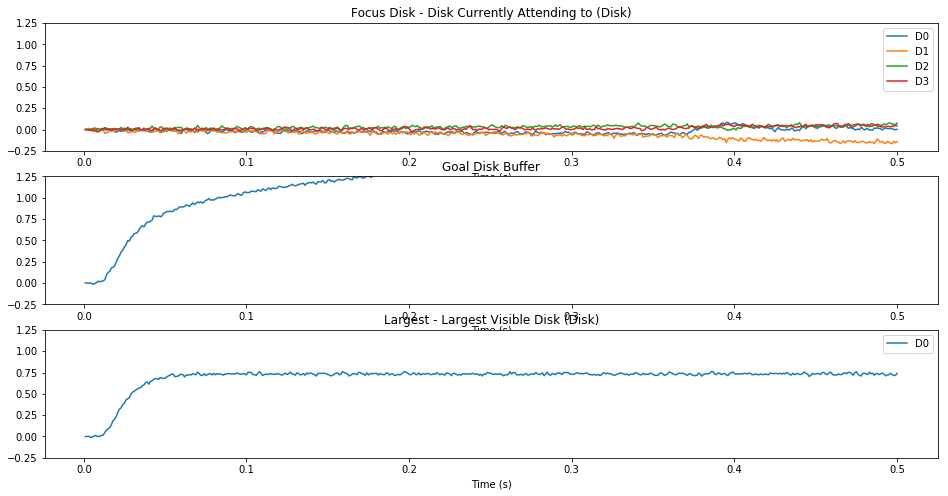

In [14]:
focus_vocab = vocab.parse('D0 * NEXT')

plt.figure(figsize=(16,8))

plt.subplot(311)
plt.plot(sim.trange(), spa.similarity(sim.data[p_buffer_focus], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Focus Disk - Disk Currently Attending to (Disk)')
plt.legend(disks_vocab, loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(312)
plt.plot(sim.trange(), spa.dot(sim.data[p_buffer_goal], focus_vocab.v))
plt.xlabel('Time (s)')
plt.title('Goal Disk Buffer')
#plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(313)
plt.plot(sim.trange(), spa.dot(sim.data[p_sensory_largest], focus_vocab.v))
plt.xlabel('Time (s)')
plt.title('Largest - Largest Visible Disk (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

(-0.25, 1.25)

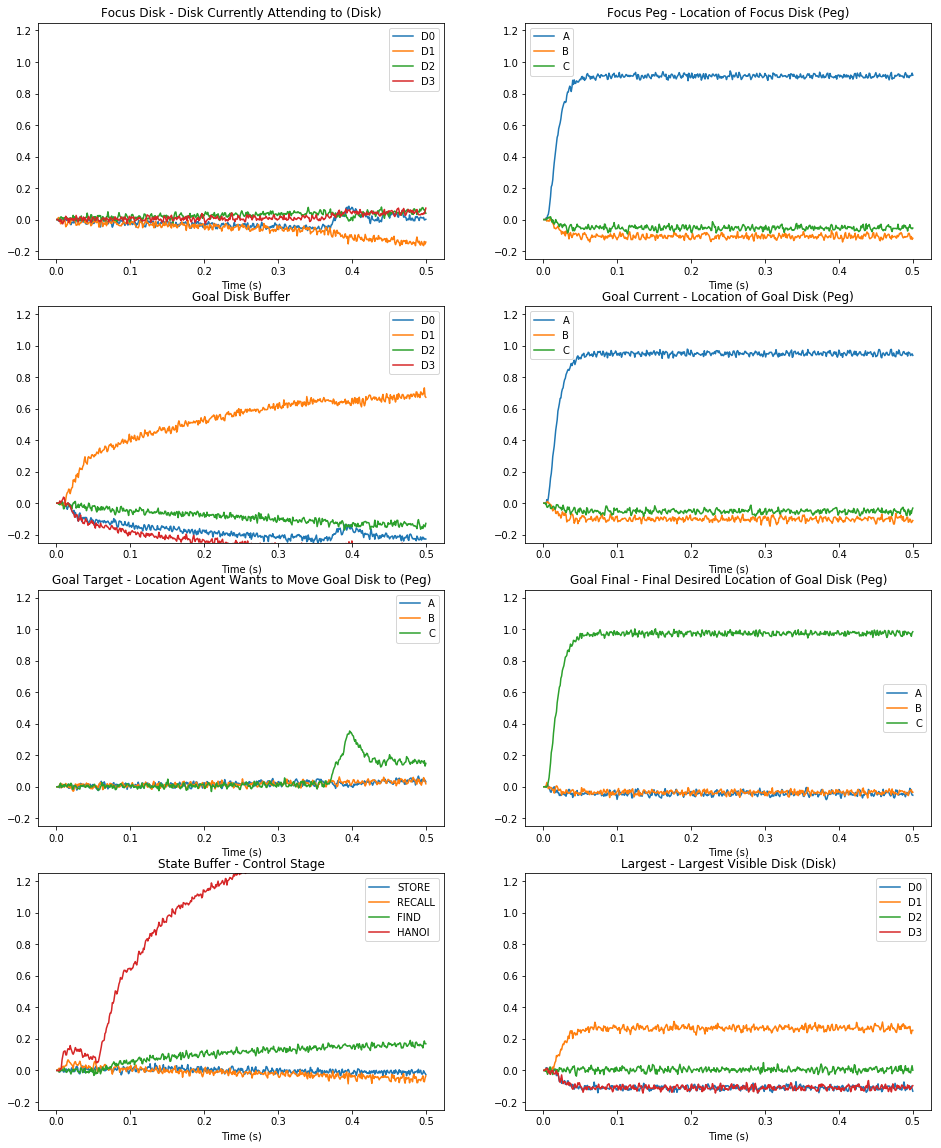

In [15]:
plt.figure(figsize=(16,20))
plt.subplot(421)
plt.plot(sim.trange(), spa.similarity(sim.data[p_buffer_focus], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Focus Disk - Disk Currently Attending to (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(422)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_focus_peg], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Focus Peg - Location of Focus Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(423)
plt.plot(sim.trange(), spa.similarity(sim.data[p_buffer_goal], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Disk Buffer')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(424)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_goal_current], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Current - Location of Goal Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(425)
plt.plot(sim.trange(), spa.similarity(sim.data[p_buffer_goal_target], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Target - Location Agent Wants to Move Goal Disk to (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(426)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_goal_final], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Final - Final Desired Location of Goal Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(427)
plt.plot(sim.trange(), spa.similarity(sim.data[p_buffer_state], state_vocab))
plt.xlabel('Time (s)')
plt.title('State Buffer - Control Stage')
plt.legend(state_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(428)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_largest], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Largest - Largest Visible Disk (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

(-0.25, 1.25)

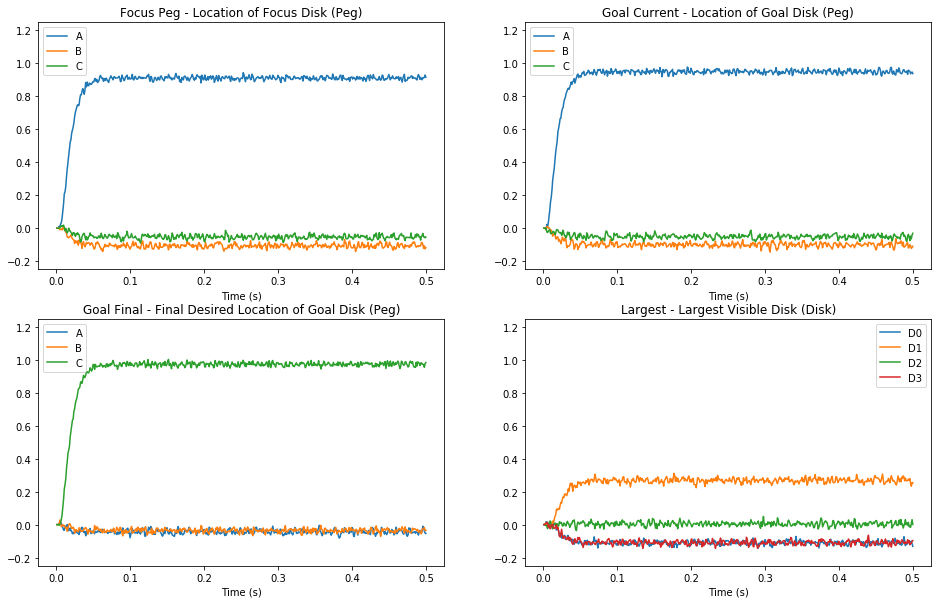

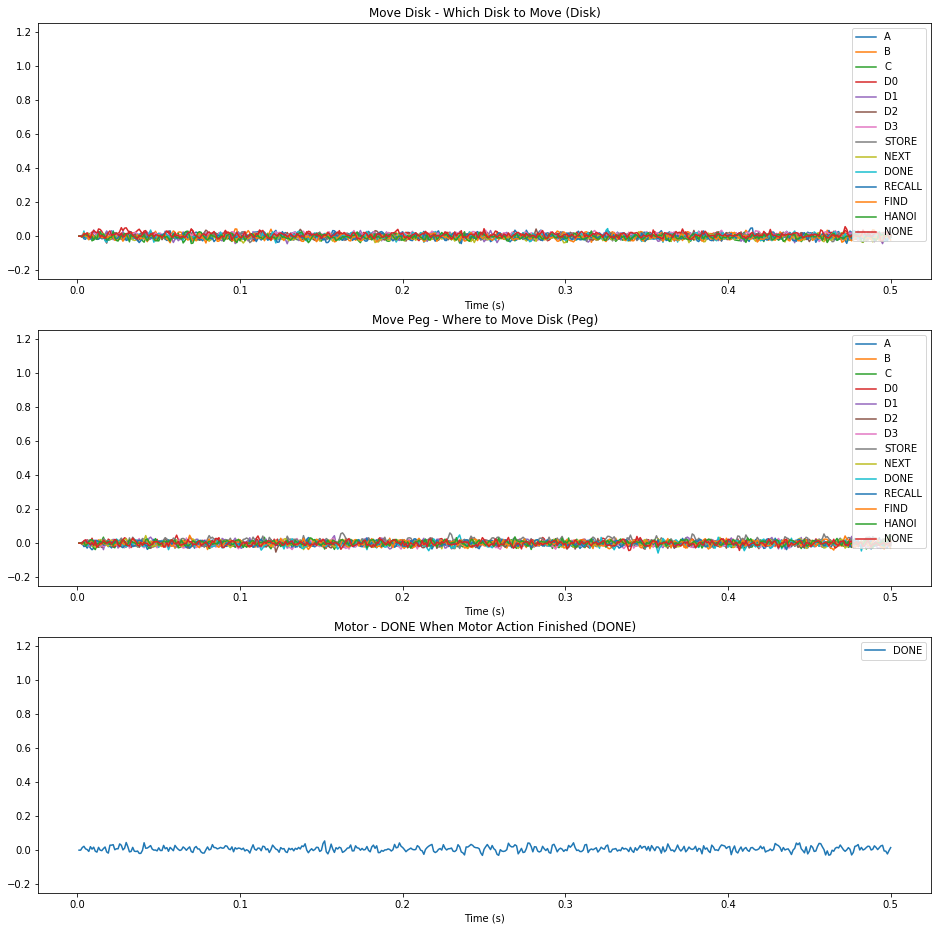

In [16]:
plt.figure(figsize=(16,10))

# sensory plots
plt.subplot(2,2,1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_focus_peg], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Focus Peg - Location of Focus Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_goal_current], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Current - Location of Goal Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_goal_final], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Goal Final - Final Desired Location of Goal Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,4)
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_largest], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Largest - Largest Visible Disk (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.figure(figsize=(16,16))

# motor plots
plt.subplot(3,1,1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_motor_move_disk], vocab))
plt.xlabel('Time (s)')
plt.title('Move Disk - Which Disk to Move (Disk)')
plt.legend(vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(3,1,2)
#[plt.plot(sim.trange(), data, color=color) for color, data in zip(vocab_colors, spa.similarity(sim.data[p_sensory_goal_current], pegs_vocab).T)]
plt.plot(sim.trange(), spa.similarity(sim.data[p_motor_move_peg], vocab))
plt.xlabel('Time (s)')
plt.title('Move Peg - Where to Move Disk (Peg)')
plt.legend(vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(3,1,3)
#[plt.plot(sim.trange(), data, color=color) for color, data in zip(vocab_colors, spa.similarity(sim.data[p_sensory_goal_current], pegs_vocab).T)]
plt.plot(sim.trange(), spa.similarity(sim.data[p_sensory_motor], done_vocab))
plt.xlabel('Time (s)')
plt.title('Motor - DONE When Motor Action Finished (DONE)')
plt.legend(done_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])


In [17]:
as_colors = [np.random.rand(3,) for color in agent.rules.action_sel.keys()]

In [18]:
keys = [key for key in agent.rules.action_sel.keys()]

# sort by most similar actions taken
get_most_similar_idx = lambda x: np.flip(np.argsort(np.sum(x, axis=0)))

most_similar_utility_idx = get_most_similar_idx(sim.data[p_utility])
most_similar_selected_actions_idx = get_most_similar_idx(sim.data[p_selected_actions])

most_similar_utility = [keys[idx] for idx in most_similar_utility_idx]
most_similar_selected_actions = [keys[idx] for idx in most_similar_selected_actions_idx]

data = {'Utility': most_similar_utility,
        'Selected Actions': most_similar_selected_actions}

df = pd.DataFrame(data, columns=['Utility', 'Selected Actions'])
display(df)

,Utility,Selected Actions
0,FindFree1,FindFree1
1,MoveDone2,MoveDone2
2,InTheWay1,FindFree2
3,Recall,LookNotDone
4,Store,MoveDone
5,StoreDone,RecallDo
6,RecallNext,MoveD0
7,LookDone,Recall
8,RecallDo,LookDone
9,LookNotDone,Store


Text(0.5,1,'Selected Action')

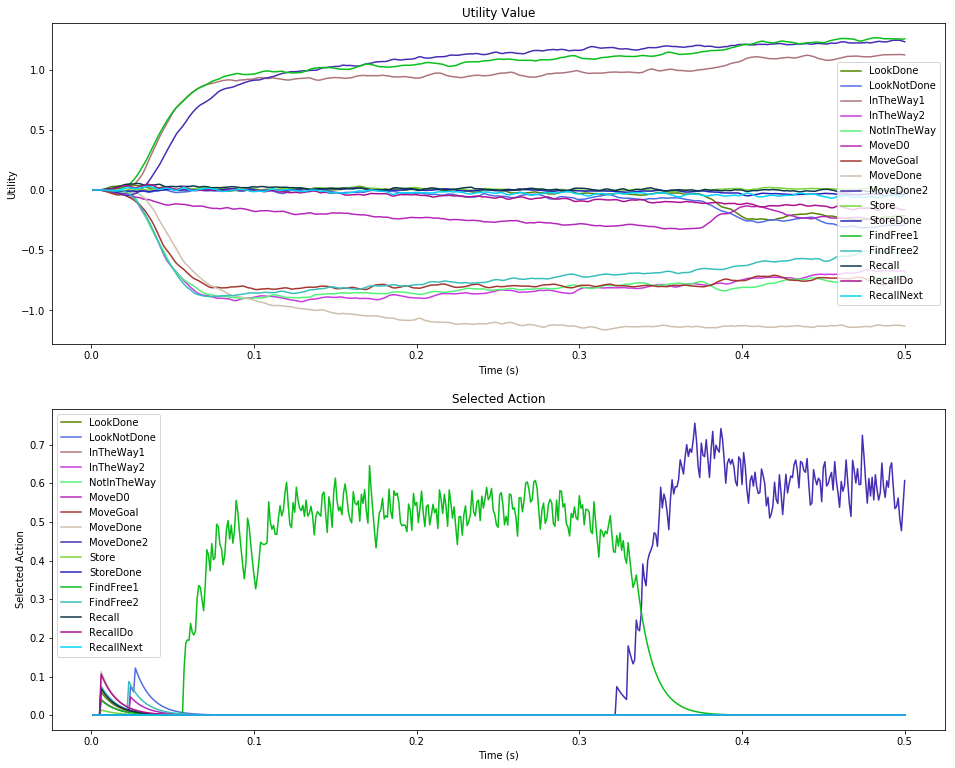

In [19]:
# plot action selection probes of agent

plt.figure(figsize=(16,13))
plt.subplot(2,1,1)
#plt.plot(sim.trange(), sim.data[p_utility])
[plt.plot(sim.trange(), data, color=color) for color, data in zip(as_colors, sim.data[p_utility].T)]
plt.legend(tuple(agent.rules.action_sel.keys()), loc='best')
plt.ylabel('Utility')
plt.xlabel("Time (s)")
plt.title('Utility Value')

#plt.figure(figsize=(16,8))
plt.subplot(2,1,2)
#plt.plot(sim.trange(), sim.data[p_selected_actions])
[plt.plot(sim.trange(), data, color=color) for color, data in zip(as_colors, sim.data[p_selected_actions].T)]
plt.legend(tuple(agent.rules.action_sel.keys()), loc='best')
plt.ylabel('Selected Action')
plt.xlabel("Time (s)")
plt.title('Selected Action')

In [20]:
actions = [key for key in agent.rules.action_sel.keys()]

Text(0.5,1,'Selected Action')

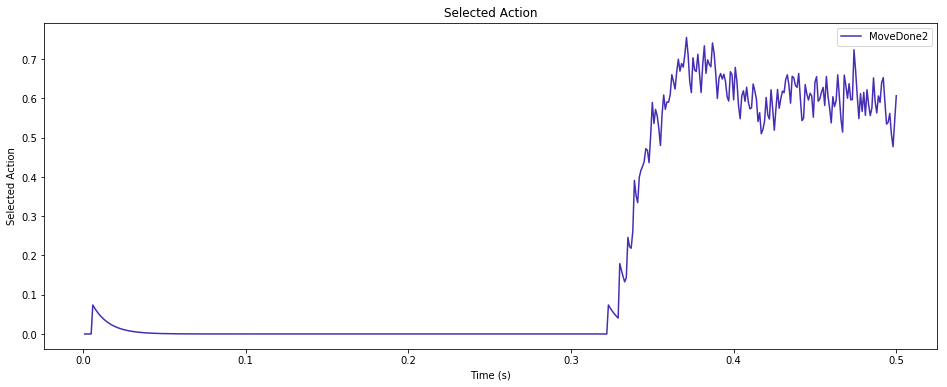

In [21]:
selected_action = 'MoveDone2'
#selected_action = 'MoveD0'
plt.figure(figsize=(16,6))
[plt.plot(sim.trange(), data, color=color) for action, color, data in zip(actions, as_colors, sim.data[p_selected_actions].T) if action == selected_action]
plt.legend([selected_action], loc='best')
plt.ylabel('Selected Action')
plt.xlabel("Time (s)")
plt.title('Selected Action')

### Environment Probes

Text(0.5,0.98,'Environment Inputs')

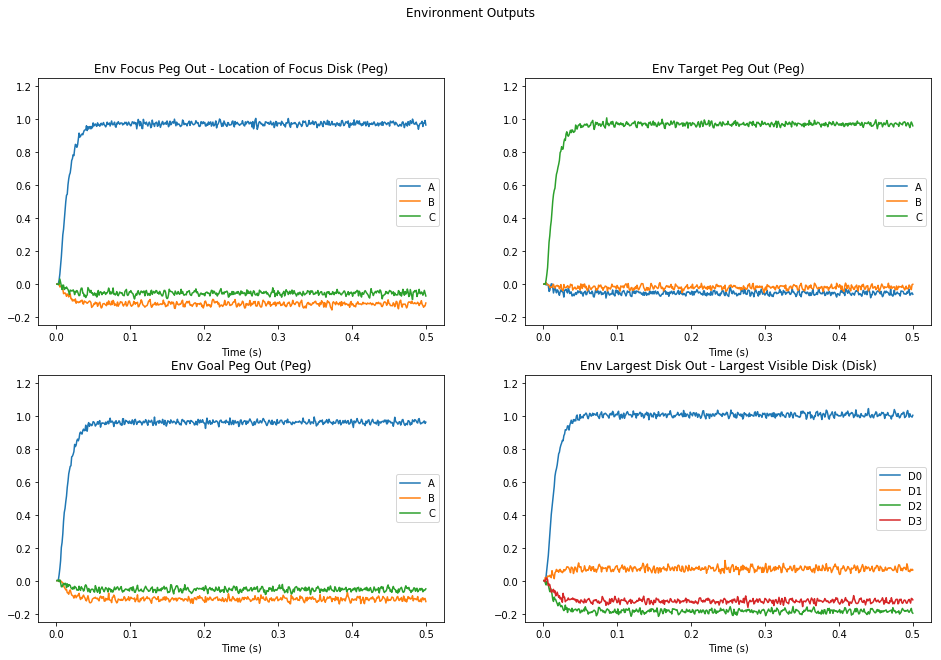

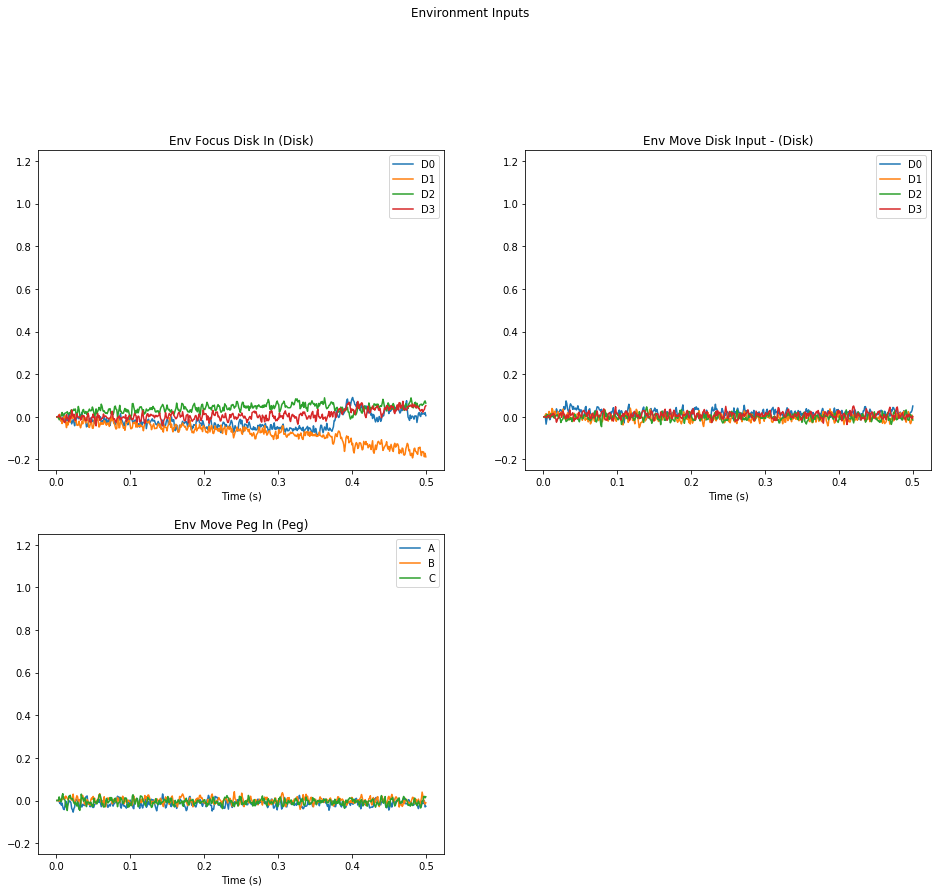

In [22]:
# plot probes of ToH environment
pegs_vocab = vocab.create_subset(['A', 'B', 'C'])
disks_vocab = vocab.create_subset(['D0', 'D1', 'D2', 'D3'])
done_vocab = vocab.create_subset(['DONE'])

plt.figure(figsize=(16,10))

# env outputs
plt.subplot(2,2,1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_focus_peg_out], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Env Focus Peg Out - Location of Focus Disk (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_target_peg_out], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Env Target Peg Out (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_goal_peg_out], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Env Goal Peg Out (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(2,2,4)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_largest_disk_out], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Env Largest Disk Out - Largest Visible Disk (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.suptitle('Environment Outputs')


plt.figure(figsize=(16,20))

# env inputs
plt.subplot(3,2,1)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_focus_disk_in], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Env Focus Disk In (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(3,2,2)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_move_disk_in], disks_vocab))
plt.xlabel('Time (s)')
plt.title('Env Move Disk Input - (Disk)')
plt.legend(disks_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.subplot(3,2,3)
plt.plot(sim.trange(), spa.similarity(sim.data[p_env_move_peg_in], pegs_vocab))
plt.xlabel('Time (s)')
plt.title('Env Move Peg In (Peg)')
plt.legend(pegs_vocab.keys(), loc='best')
plt.ylim([-.25, 1.25])

plt.suptitle('Environment Inputs')